In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, threshold=500)
pd.options.display.max_rows = 100
%matplotlib inline
import sys
sys.path.insert(0,'/usr/local/Cellar/opencv3/3.2.0/lib/python2.7/site-packages')
import cv2
from PIL import Image

# PIL基本变换

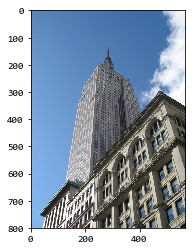

In [2]:
pil_im = Image.open("../datasets/ComputerVisionPython/empire.jpg")
plt.imshow(pil_im)

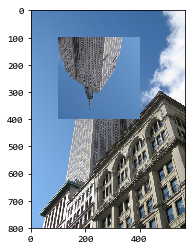

In [3]:
box = (100, 100, 400, 400)
region = pil_im.crop(box)
region = region.transpose(Image.ROTATE_180)
pil_im.paste(region, box)
plt.imshow(pil_im)

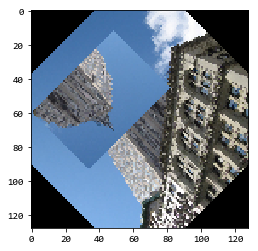

In [4]:
out = pil_im.resize((128,128))
out = out.rotate(45)
plt.imshow(out)

# 交互式标注

Please click 3 points
This is implemented only for backends with GUIs.


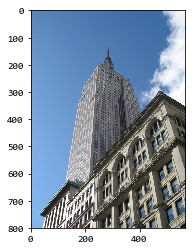

In [5]:
im = Image.open("../datasets/ComputerVisionPython/empire.jpg")
plt.imshow(im)
print "Please click 3 points"
try:
    x = plt.ginput(3)
    print x
except NotImplementedError:
    print "This is implemented only for backends with GUIs."
plt.show()

# 直方图均衡化
*使用CLAHE算法效果更好*

In [6]:
def histeq(im, nbr_bins=256):
    """对一幅灰度图像进行直方图均衡化"""
    
    # 计算图像的直方图
    imhist, bins = np.histogram(im.flatten(), nbr_bins, normed=True)
    # 计算累计分布函数（cumulative distribution function）
    cdf = imhist.cumsum() # 累计分布函数
    cdf = 255 * cdf / cdf[-1] # 归一化
    # 使用累计分布函数的线性插值，计算新的像素值
    im2 = np.interp(im.flatten(), bins[:-1], cdf)
    
    return im2.reshape(im.shape), cdf

In [7]:
im = np.array(Image.open("../datasets/ComputerVisionPython/AquaTermi_lowcontrast.JPG").convert("L"))
im2, cdf = histeq(im)

## 直方图均衡化前

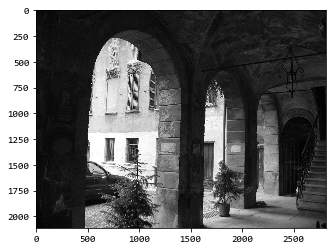

In [8]:
plt.imshow(im, cmap="gray")

## 直方图均衡化后(对比度增强)

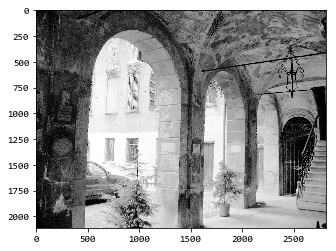

In [9]:
plt.imshow(im2, cmap="gray")

# 图像的主成分分析(PCA)

In [10]:
def pca(X):
    """主成分分析：
        输入：矩阵X，其中该矩阵中存储训练数据，每一行为一条训练数据
        返回：投影矩阵（按照维度的重要性排序）、方差和均值"""
    
    # 获取维数
    num_data, dim = X.shape
    
    # 数据中心化
    mean_X = X.mean(axis=0)
    X = X - mean_X
    
    if dim > num_data:
        # PCA-使用紧致技巧
        M = np.dot(X, X.T) # 协方差矩阵
        e, EV = np.linalg.eigh(M) # 特征值和特征向量
        tmp = np.dot(X.T, EV) # 这就是紧致技巧
        V = tmp[::-1] # 由于最后的特征向粮食我们所需要的，所以需要将其逆转
        S = np.sqrt(e)[::-1] # 由于特征值是按照递增顺序排列的，所以需要将其逆转
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA使用SVD方法
        U, S, V = np.linalg.svd(X)
        V = V[:num_data] # 仅仅返回前num_data维的数据才合理
        
    # 返回投影矩阵
    return V, S, mean_X

In [11]:
import glob
imlist = glob.glob("../datasets/ComputerVisionPython/a_thumbs/*.jpg")
im = np.array(Image.open(imlist[0]))
m, n = im.shape[0:2]
imnbr = len(imlist)

# 创建矩阵，保存所有压平后的图像数据
immatrix = np.array([np.array(Image.open(im)).flatten() for im in imlist], "f")

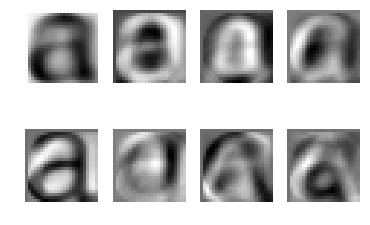

In [12]:
V, S, immean = pca(immatrix)
plt.figure()
plt.gray()
subplt = plt.subplot(2,4,1)
subplt.axis("off")
plt.imshow(immean.reshape(m, n))
for i in range(7):
    subplt = plt.subplot(2,4,i+2)
    subplt.axis("off")
    plt.imshow(V[i].reshape(m,n))
plt.show()

# 图像模糊
图像的*高斯模糊*本质上市将(灰度)图像$I$和一个高斯核进行卷积操作:
$$I_\sigma = I*G_\sigma$$
$*$表示卷积操作，$G_\sigma$是标准差为$\sigma$的二维高斯核，定义为:
$$G_\sigma = \frac{1}{2\pi\sigma^2}e^{-(x^2+y^2)/2\sigma^2}$$

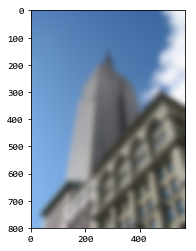

In [13]:
from scipy.ndimage import filters
im = np.array(Image.open("../datasets/ComputerVisionPython/empire.jpg"))
im2 = np.zeros(im.shape)
for i in range(3):
    im2[:,:,i] = filters.gaussian_filter(im[:,:,i], 10)
im2 = np.uint8(im2)
plt.imshow(im2)

# 图像导数
图像的强度片花是一个非常重要的信息。强度的变化可以通过灰度图像$I$(对于彩色图像，通常对每个颜色通道分别计算导数)的$x$和$y$方向导数$I_x$和$I_y$进行描述。
图像的*梯度向量*为$\nabla I=[I_x,I_y]^T$。梯度有两个重要属性，一是*梯度的大小*:
$$|\nabla I|=\sqrt{I_x^2+I_y^2}$$
它描述了图像强度变化的强弱，一是*梯度的角度*:
$$\alpha=arctan2(I_y,I_x)$$
描述了图像中每个点(像素)上强度变化最大的反向。
我们可以用离散近似的方式来计算图像的导数。图像的导数大多数可以通过卷积简单地实现:
$$I_x=I*D_x和I_y=I*D_y$$
对于$D_x$和$D_y$，通常选择Prewitt滤波器:
$$D_x=\begin{bmatrix}-1&0&1\\-1&0&1\\-1&0&1\\\end{bmatrix} 和 D_y=\begin{bmatrix}-1&-1&-1\\0&0&0\\1&1&1\\\end{bmatrix}$$
或者Sobel滤波器:
$$D_x=\begin{bmatrix}-1&0&1\\-2&0&2\\-1&0&1\\\end{bmatrix} 和 D_y=\begin{bmatrix}-1&-2&-1\\0&0&0\\1&2&1\\\end{bmatrix}$$

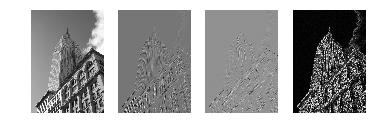

In [14]:
from scipy.ndimage import sobel
im = np.array(Image.open("../datasets/ComputerVisionPython/empire.jpg").convert("L"))
# Sobel滤波器
imx = np.zeros(im.shape)
sobel(im, 1, imx)

imy = np.zeros(im.shape)
sobel(im, 0, imy)

magnitude = np.uint8(np.sqrt(imx**2+imy**2))

plt.figure()
plt.gray()
subplt = plt.subplot(1,4,1)
subplt.axis("off")
plt.imshow(im)
subplt = plt.subplot(1,4,2)
subplt.axis("off")
plt.imshow(imx)
subplt = plt.subplot(1,4,3)
subplt.axis("off")
plt.imshow(imy)
subplt = plt.subplot(1,4,4)
subplt.axis("off")
plt.imshow(magnitude)
plt.show()

# 高斯导数滤波器

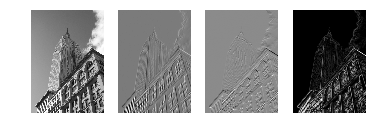

In [15]:
from scipy.ndimage import gaussian_filter
sigma = 2

imx = np.zeros(im.shape)
gaussian_filter(im, (sigma, sigma), (0,1), imx)

imy = np.zeros(im.shape)
gaussian_filter(im, (sigma, sigma), (1,0), imy)

magnitude = np.uint8(np.sqrt(imx**2+imy**2))

plt.figure()
plt.gray()
subplt = plt.subplot(1,4,1)
subplt.axis("off")
plt.imshow(im)
subplt = plt.subplot(1,4,2)
subplt.axis("off")
plt.imshow(imx)
subplt = plt.subplot(1,4,3)
subplt.axis("off")
plt.imshow(imy)
subplt = plt.subplot(1,4,4)
subplt.axis("off")
plt.imshow(magnitude)
plt.show()